In [1]:
from model import *
from data import *

## Train your Unet with membrane data
membrane data is in folder membrane/, it is a binary classification task.

The input shape of image and mask are the same :(batch_size,rows,cols,channel = 1)

### Train with data generator

In [2]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,'data/membrane/train','CFD_img','CFD_mask',data_gen_args,save_to_dir = None)
model = unet()
model_checkpoint = ModelCheckpoint('unet_relu.h5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=1000,epochs=5,callbacks=[model_checkpoint])




c:\Users\user\anaconda3\envs\unet_tf26\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
c:\Users\user\anaconda3\envs\unet_tf26\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [3]:
def predict_and_visualize_images(model_filename, image_folder, label_folder, num_images=5, traget_size=(256, 256)):
    # 加载模型
    model = tf.keras.models.load_model(model_filename)

    # 列出文件夹中的所有图像文件
    image_files = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder) if filename.endswith('.png')]

    # 随机选择指定数量的图像
    selected_images = random.sample(image_files, num_images)

    for image_path in selected_images:
        # 读取原始图像和ground truth
        original_image = Image.open(image_path)
        ground_truth_path = os.path.join(label_folder, os.path.basename(image_path))  # 使用 ground_truth_folder 参数
        ground_truth_image = Image.open(ground_truth_path)

        # 调整图像大小
        original_image = original_image.resize(traget_size)
        ground_truth_image = ground_truth_image.resize(traget_size)

        input_image_array = np.array(original_image)
        ground_truth_array = np.array(ground_truth_image)

        input_image_array = np.expand_dims(input_image_array, axis=-1)
        ground_truth_array = np.expand_dims(ground_truth_array, axis=-1)

        predictions = model.predict(np.expand_dims(input_image_array, axis=0))
        output_image = (predictions[0] * 255).astype(np.uint8)
        

        # 提取图像文件名（不带路径）
        image_filename = os.path.basename(image_path)

        # 显示原始图像、ground truth和预测结果图像
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(original_image, cmap='gray')  # 显示原始图像
        plt.title('Original Image', fontsize=14)

        plt.subplot(1, 3, 2)
        plt.imshow(ground_truth_image, cmap='gray')  # 显示ground truth
        plt.title('Ground Truth', fontsize=14)

        plt.subplot(1, 3, 3)
        plt.imshow(output_image, cmap='gray')  # 显示预测图像
        plt.title('Predicted Image', fontsize=14)
        plt.suptitle(image_filename, fontsize=16)
        plt.show()

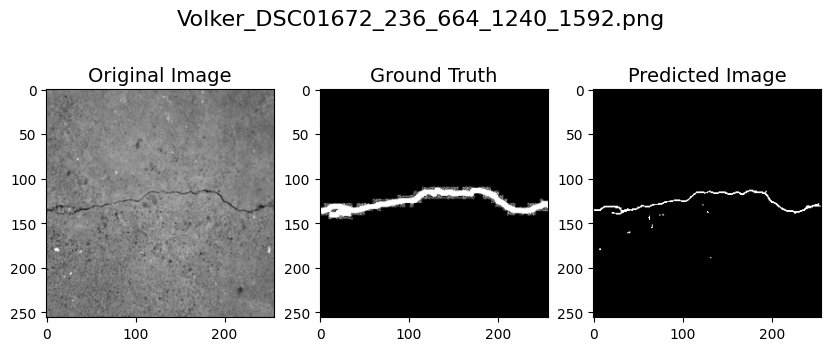

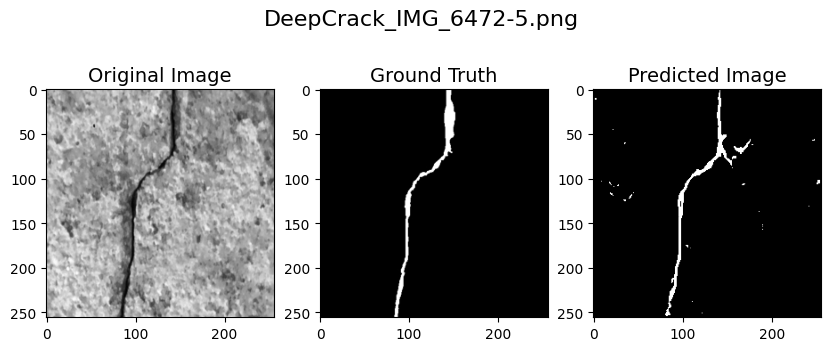

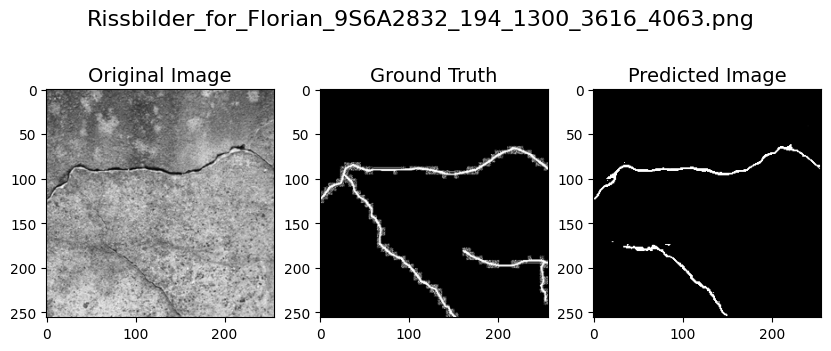

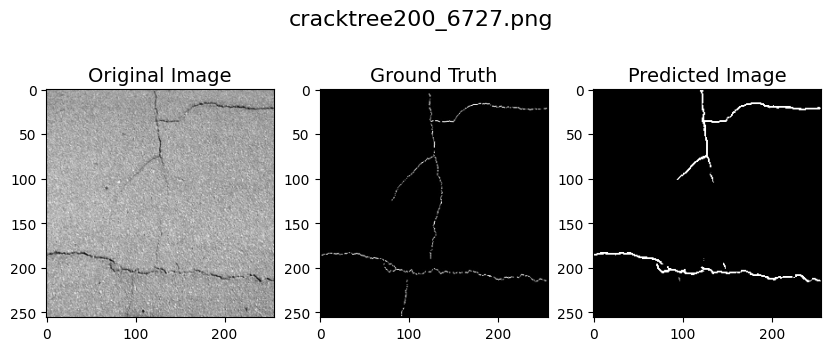

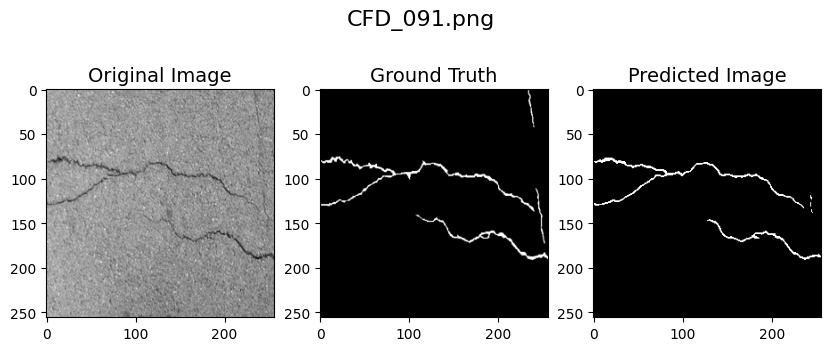

In [5]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import *
img_folder=r"d:\Users\user\Desktop\CFD\test5"
label_folder=r"d:\Users\user\Desktop\CFD\test5_mask"
model="unet_relu.h5"
predict_and_visualize_images(model,img_folder, label_folder, num_images=5,traget_size=(256, 256))

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, jaccard_score

def predict_image(model, image_path, label_folder, target_size=(256, 256)):
        original_image = Image.open(image_path)
        ground_truth_path = os.path.join(label_folder, os.path.basename(image_path))
        ground_truth_image = Image.open(ground_truth_path)

        input_image = original_image.resize(target_size)
        ground_truth_image = ground_truth_image.resize(target_size)

        input_image_array = np.array(input_image)
        ground_truth_array = np.array(ground_truth_image)

        input_image_array = np.expand_dims(input_image_array, axis=-1)
        ground_truth_array = np.expand_dims(ground_truth_array, axis=-1)

        predictions = model.predict(np.expand_dims(input_image_array, axis=0))
        

        return predictions, ground_truth_array

def compute_confusion_metrics(predictions, ground_truths, threshold=0.5):
    binary_predictions = (predictions > threshold).astype(np.uint8)
    binary_ground_truths = (ground_truths > 0.5).astype(np.uint8)

    confusion_mat = confusion_matrix(binary_ground_truths.flatten(), binary_predictions.flatten())

    print("Confusion Matrix:")
    print(confusion_mat)

    accuracy = accuracy_score(binary_ground_truths.flatten(), binary_predictions.flatten())
    precision_metric = precision_score(binary_ground_truths.flatten(), binary_predictions.flatten())
    recall = recall_score(binary_ground_truths.flatten(), binary_predictions.flatten())
    jaccard_similarity = jaccard_score(binary_ground_truths.flatten(), binary_predictions.flatten())

    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision_metric))
    print("Recall: {:.4f}".format(recall))
    print("Jaccard Similarity: {:.4f}".format(jaccard_similarity))

def main():
    # 加载模型
    model = tf.keras.models.load_model(model_filename)

    # 获取测试图像文件列表
    test_image_files = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder) if filename.endswith('.png')]

    # 初始化列表来存储所有预测和真实标签
    all_predictions = []
    all_ground_truths = []
    
    # 遍历所有测试图像并获取预测和真实标签
    for image_path in test_image_files:
        predictions, ground_truth = predict_image(model, image_path, label_folder)
        all_predictions.append(predictions)
        all_ground_truths.append(ground_truth)

    # 将列表转换为NumPy数组
    all_predictions = np.array(all_predictions)
    all_ground_truths = np.array(all_ground_truths)

    # 计算混淆矩阵和性能指标
    compute_confusion_metrics(all_predictions, all_ground_truths, threshold=0.5)

if __name__ == "__main__":
    model_filename = 'unet_relu.h5'
    image_folder = r'd:\Users\user\Desktop\CFD\test5'
    label_folder = r'd:\Users\user\Desktop\CFD\test5_mask'
    main()

Confusion Matrix:
[[309890    786]
 [ 12151   4853]]
Accuracy: 0.9605
Precision: 0.8606
Recall: 0.2854
Jaccard Similarity: 0.2728


In [ ]:
# 调用 trainGenerator 函数并创建一个数据生成器
data_generator = trainGenerator(2,'data/membrane/train','CFD_img','CFD_mask',data_gen_args,save_to_dir = None)


# 初始化计数器
total_images = 0

# 遍历生成器中的数据，逐一迭代并计算总数量
for batch in data_generator:
    total_images += batch[0].shape[0]  # 这里假设 batch[0] 包含了图像数据

# 打印总图片数量
print("Total images for training:", total_images)



### Train with npy file

In [ ]:
#imgs_train,imgs_mask_train = geneTrainNpy("data/membrane/train/aug/","data/membrane/train/aug/")
#model.fit(imgs_train, imgs_mask_train, batch_size=2, nb_epoch=10, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])

### test your model and save predicted results

In [4]:
import tensorflow as tf
from PIL import Image

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, jaccard_score

def predict_single_image(model, image_path, label_path, target_size=(256, 256)):
    original_image = Image.open(image_path)
    ground_truth_image = Image.open(label_path)

    input_image = original_image.resize(target_size)
    ground_truth_image = ground_truth_image.resize(target_size)

    input_image_array = np.array(input_image)
    ground_truth_array = np.array(ground_truth_image)

    input_image_array = np.expand_dims(input_image_array, axis=-1)
    ground_truth_array = np.expand_dims(ground_truth_array, axis=-1)

    predictions = model.predict(np.expand_dims(input_image_array, axis=0))

    return predictions, ground_truth_array

def compute_confusion_metrics(predictions, ground_truths, threshold=0.5):
    binary_predictions = (predictions > threshold).astype(np.uint8)
    binary_ground_truths = (ground_truths > 0.3).astype(np.uint8)

    confusion_mat = confusion_matrix(binary_ground_truths.flatten(), binary_predictions.flatten())

    print("Confusion Matrix:")
    print(confusion_mat)

    accuracy = accuracy_score(binary_ground_truths.flatten(), binary_predictions.flatten())
    precision_metric = precision_score(binary_ground_truths.flatten(), binary_predictions.flatten())
    recall = recall_score(binary_ground_truths.flatten(), binary_predictions.flatten())
    jaccard_similarity = jaccard_score(binary_ground_truths.flatten(), binary_predictions.flatten())

    # 计算F1分数
    f1_score = 2 * (precision_metric * recall) / (precision_metric + recall)
    print("=======================================================================")
    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision_metric))
    print("Recall: {:.4f}".format(recall))
    print("F1 Score: {:.4f}".format(f1_score))
    print("Jaccard Similarity: {:.4f}".format(jaccard_similarity))


def main():
    # 加载模型
    model = tf.keras.models.load_model(model_filename)

    # 单个图像文件路径
    image_path = r'd:\Users\user\Desktop\CFD\test5\CFD_091.png'
    label_path = r'd:\Users\user\Desktop\CFD\test5_mask\CFD_091.png'

    # 获取单个图像的预测和真实标签
    predictions, ground_truth = predict_single_image(model, image_path, label_path)

    # 计算混淆矩阵和性能指标
    compute_confusion_metrics(predictions, ground_truth, threshold=0.5)

if __name__ == "__main__":
    model_filename = 'unet_cfd.h5'
    main()


Confusion Matrix:
[[62239    58]
 [ 2123  1116]]
Accuracy: 0.9667
Precision: 0.9506
Recall: 0.3446
F1 Score: 0.5058
Jaccard Similarity: 0.3385


In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, jaccard_score

# 随机生成标签和预测数组（这里使用随机数生成，你可以根据你的实际数据替换它们）
np.random.seed(42)  # 为了保证随机数的可重复性
labels = np.random.randint(0, 2, (3, 3))  # 随机生成0和1的标签数组
predictions = np.random.rand(3, 3)  # 随机生成0到1之间的预测数组

# 打印标签数组和预测数组
print("Labels:")
print(labels)

print("\nPredictions:")
print(predictions)

# 使用你的函数来计算混淆矩阵和性能指标
compute_confusion_metrics(predictions, labels, threshold=0.4)


Labels:
[[0 1 0]
 [0 0 1]
 [0 0 0]]

Predictions:
[[0.44583275 0.09997492 0.45924889]
 [0.33370861 0.14286682 0.65088847]
 [0.05641158 0.72199877 0.93855271]]
Confusion Matrix:
[[3 4]
 [1 1]]
Accuracy: 0.4444
Precision: 0.2000
Recall: 0.5000
F1 Score: 0.2857
Jaccard Similarity: 0.1667
